# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureTest.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 188) Taille du dataset de test ECG : (1000, 188)
Taille de la base d apprentissage Features : (4000, 156) Taille du dataset de test Features : (1000, 156)


In [11]:
label_name = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

## Vecteur médian des caractéristiques pour chaque classe

In [5]:
# Calculer le vecteur médian des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques avec numpy
unique_labels = np.unique(LabelF_train)
print("Classes uniques :", unique_labels)

for label in unique_labels:
  Data_App_Temp= DataFeatureApp[:,:32]
  # Filtrer les données pour la classe actuelle
  class_features = Data_App_Temp[np.array(LabelF_train) == label]
    # Calculer la médiane des caractéristiques pour cette classe
  class_median = np.median(class_features, axis=0)  # Utilisation de np.median()
  class_feature_medians[label] = class_median

# Afficher les résultats
#for label, median_vector in class_feature_medians.items():
   # print(f"Vecteur médian pour la classe {label} : {median_vector}")

Classes uniques : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

In [6]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


In [7]:
ListeVariablesTemps

array(['0_Area under the curve', '0_Autocorrelation', '0_Centroid',
       '0_Mean absolute diff', '0_Mean diff', '0_Median absolute diff',
       '0_Median diff', '0_Negative turning points',
       '0_Neighbourhood peaks', '0_Positive turning points',
       '0_Signal distance', '0_Slope', '0_Sum absolute diff',
       '0_Zero crossing rate'], dtype=object)

### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [8]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



information (alban) : On veut comparer les caracteristiques du jeu de test aux valeurs médianes (par exemple)   du jeu de test pour chaque classe ( car on sait a quel classe chaque battement appartient)

On a un ensemble de caracteristique par battement et on veut les comparér via l'algo DTW, celui dont on est le plus proche alors on peut le classer comme étant un battement de ce type la ( il faut comparer a chaque classe ).

In [9]:
from math import *
import sys

In [10]:

def DTW(A, B, d):
    """
    Algorithme DTW avec poids pour aligner deux séries temporelles.

    Args:
        A (list or np.ndarray): Première série temporelle.
        B (list or np.ndarray): Deuxième série temporelle.
        d (function): Fonction de distance locale entre deux points.

    Returns:
        float: Score d'alignement.
        np.ndarray: Matrice des coûts cumulés.
    """
    # Définir les poids des transitions
    w0 = 1  # Poids pour l'insertion
    w1 = 2  # Poids pour la correspondance
    w2 = 1  # Poids pour la suppression

    N, M = len(A), len(B)

    # Initialisation de la matrice des coûts avec des valeurs infinies
    g = np.full((N + 1, M + 1), float('inf'))
    g[0, 0] = 0  # Point de départ

    # Initialisation des premières lignes et colonnes
    for j in range(1, M + 1):
        g[0, j] = float('inf')
    for i in range(1, N + 1):
        g[i, 0] = float('inf')

    # Remplissage de la matrice des coûts
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = d(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * cost,     # Transition (i-1, j)
                g[i - 1, j - 1] + w1 * cost,  # Transition (i-1, j-1)
                g[i, j - 1] + w2 * cost      # Transition (i, j-1)
            )

    # Score d'alignement
    S = g[N, M] / (N + M)
    return S, g


In [ ]:

# Exemple de fonction de distance locale
def distance(a, b):
    return abs(a - b)

# Fonction pour appliquer DTW sur l'ensemble du test
def apply_dtw_on_test(DataFeatureTest, LabelF_test, DataFeatureApp, LabelF_train):
    results = []

    # Appliquer DTW pour chaque pair d'éléments (test, train)
    for test_idx, test_series in enumerate(DataFeatureTest):  # On itère directement sur un ndarray
        # Initialiser la meilleure correspondance
        best_distance = float('inf')
        best_path = []

        # Comparer avec chaque série d'entraînement
        for train_idx, train_series in enumerate(DataFeatureApp):  # Idem ici pour DataFeatureApp
            # Appliquer DTW
            distance_value, path = DTW(test_series, train_series, distance)

            # Si la distance calculée est meilleure, on l'enregistre
            if distance_value < best_distance:
                best_distance = distance_value
                best_path = path

        # Ajouter le résultat de la correspondance pour cet exemple de test
        results.append((best_distance, best_path))

    return results

# Appliquer DTW sur l'ensemble du jeu de test
results = apply_dtw_on_test(DataFeatureTest, LabelF_test, DataFeatureApp, LabelF_train)

# Affichage des résultats
for idx, (dist, path) in enumerate(results):
    print(f"Test {idx}: Distance = {dist}, Path = {path}")


## Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [ ]:
# Système de reconnaissance à partir de la DTW
PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))

## à coder

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [ ]:
# Evaluation des résultats par matrices de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [ ]:
print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(classe[:N_CLASSES]),yticklabels=np.unique(classe[:N_CLASSES]),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

In [3]:
# arbre de decision
# méthode de classification supervisé

from sklearn.tree import DecisionTreeClassifier

# Initialiser et entraîner le modèle
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(DataFeatureApp, LabelF_train)

# Prédictions
y_pred_dt = dt_model.predict(DataFeatureTest)

In [4]:
# k-Nearest Neighbors
# méthode de classification supervisé

from sklearn.neighbors import KNeighborsClassifier

# Initialiser et entraîner le modèle
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(DataFeatureApp, LabelF_train)

# Prédictions
y_pred_knn = knn_model.predict(DataFeatureTest)

In [5]:
# matrice de confusion des deux méthodes supervisé
from sklearn.metrics import confusion_matrix

# Matrice de confusion pour l'arbre de décision
conf_matrix_dt = confusion_matrix(LabelF_test, y_pred_dt)
print("Matrice de confusion pour l'Arbre de Décision :\n", conf_matrix_dt)

# Matrice de confusion pour k-NN
conf_matrix_knn = confusion_matrix(LabelF_test, y_pred_knn)
print("Matrice de confusion pour k-NN :\n", conf_matrix_knn)


Matrice de confusion pour l'Arbre de Décision :
 [[158  30  19   5   4]
 [ 30 153   5   1   1]
 [  9   4 169   6   4]
 [  2   2   2 204   0]
 [  4   5   4   5 174]]
Matrice de confusion pour k-NN :
 [[137  41  21  14   3]
 [ 43 137   6   3   1]
 [ 28   2 132  12  18]
 [  4   1   2 203   0]
 [  7   4   1   9 171]]


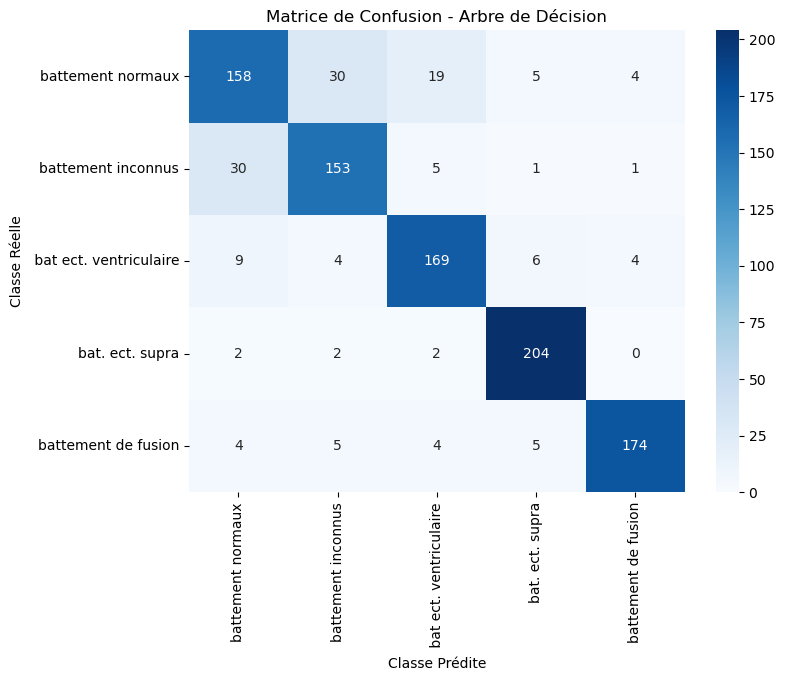

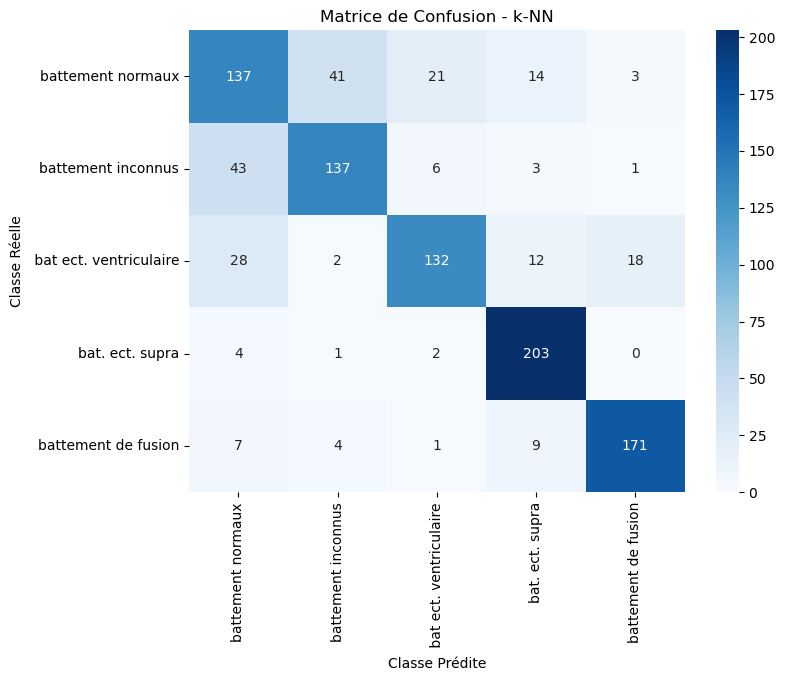

In [12]:
# Fonction pour visualiser la matrice de confusion
def plot_confusion_matrix(cm, class_names, title="Matrice de Confusion"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Classe Réelle')
    plt.xlabel('Classe Prédite')
    plt.show()

# Classes réelles 
class_names = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

# Visualisation des matrices de confusion
plot_confusion_matrix(conf_matrix_dt, class_names, "Matrice de Confusion - Arbre de Décision")
plot_confusion_matrix(conf_matrix_knn, class_names, "Matrice de Confusion - K-NN")


In [ ]:
TESTER AVEC DIFFÉRENT PARAMETRE DES METHODES, TESTER SANS EXTRACTION DES CARACTÉRISTIQUES

## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Calcul de la matrice de confusion


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [ ]:
# Calcul de la matrice de confusion



# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
